<a href="https://colab.research.google.com/github/nazligungor/FinalProject/blob/master/Copy_of_ActorGenreRnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files
uploaded = files.upload()
import io
#df2 = pd.read_csv(io.BytesIO(uploaded['Filename.csv']))

Saving titles.tsv to titles (1).tsv
Saving names.tsv to names.tsv


In [0]:
import pandas as pd

#replace file name with relative location in your local folder
name_basics = pd.read_csv(io.BytesIO(uploaded['names.tsv']), delimiter = "\t")
title_basics = pd.read_csv(io.BytesIO(uploaded['titles.tsv']), delimiter = "\t")

#selects people who are listed as an actor/actress
is_actor = name_basics['primaryProfession'].str.contains("actor") | name_basics['primaryProfession'].str.contains("actress")

name_actor = name_basics[is_actor]

#filters out actor/actress with no known titles
has_title = name_actor['knownForTitles'] != '\\N'
name_actor = name_actor[has_title]

has_genre = title_basics['genres'] != '\\N'
title_basics = title_basics[has_genre]

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
genre_list = []

#creates a new column genres in name_actor by referencing known titles and retrieving genre data.
for index, row in name_actor.iterrows():
    title_str = row['knownForTitles']
    title_list = title_str.split(",")
    genre_str = ''
    for i in title_list:
        title_index = title_basics.index[title_basics['tconst'] == i].tolist()
        if len(title_index) == 0:
            continue
        title_row = title_basics.at[title_index[0], 'genres']
        genre_str += title_row + ','
    genre_str = genre_str[:-1]
    genre_list.append(genre_str)


name_actor.insert(6,"genre", genre_list)

KeyboardInterrupt: ignored

In [0]:
import binascii
#get table with only specific columns
name_genre = name_actor[['nconst', 'primaryName', 'genre']]

#make dictionary mapping genres to ints
#d = {}
#i = 0
#for genre in top_genre:
#    if genre not in d:
#        d[genre] = i
#        i+= 1

top_genres = []
for index, row in name_genre.iterrows():
    genres = name_genre.at[index, 'genre'].split(',')
    d = {}
    for genre in genres:
        if genre not in d:
            d[genre] = 0
        d[genre] += 1
    sorted_d = sorted(d.items(), key = lambda t: t[1], reverse=True)
    top = []
    for i in range(3):
        if len(sorted_d) >= i + 1:
            top.append(sorted_d[i][1])
    top_genres.append(top)

name_genre.insert(3, 'top genres', top_genres)

#make name_genre only have the top 3 genres for each actor
name_genre = name_genre.drop(columns=['genre'])


#convert str names to unique int representations
names = name_genre['primaryName']
names_nums = []
for name in names:
    name_hex = binascii.hexlify(name.encode('utf-8'))
    names_nums.append(int(name_hex, 16))
        
#get top genre for each actor
top_genre = []
for index, row in name_genre.iterrows():
    top_genre.append(name_genre.at[index, 'top genres'][0])

#get list of genres by their int representations
#genre_nums = []
#for genre in top_genre:
#    genre_nums.append(d[genre])

name_genre_identifiers = name_genre.drop(columns=['nconst', 'top genres'])
name_genre_identifiers['top genre'] = top_genre
name_genre_identifiers.to_csv('name_genre_identifiers.csv')

In [0]:
### above this cell is just setting data up for the model ###
### here is where we create and test the model ###
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import metrics
%matplotlib inline
names = name_genre_identifiers['primaryName']
top_genre = name_genre_identifiers['top genre']

X_train, X_test, y_train, y_test = train_test_split(names, top_genre, test_size=0.2, random_state=0)


In [1]:
from google.colab import files
uploaded = files.upload()
import io

Saving name_genre_identifiers_final.csv to name_genre_identifiers_final.csv


In [0]:
import pandas as pd
name_genre_identifiers = pd.read_csv('name_genre_identifiers_final.csv')

In [0]:
names = name_genre_identifiers['primaryName']
top_genre = name_genre_identifiers['top genre']


In [0]:
import torch
import unicodedata
import string


# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor


In [5]:
import torch.nn as nn
new_d = {}
#print(top_genre)
i = 0
for genre in top_genre:
    if genre not in new_d:
        new_d[genre] = i
        i+= 1

ind= {k:i for i,k in enumerate(new_d.keys())}
#print(ind)
print(type(names))

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
n_categories = len(new_d)

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

<class 'pandas.core.series.Series'>


TypeError: ignored

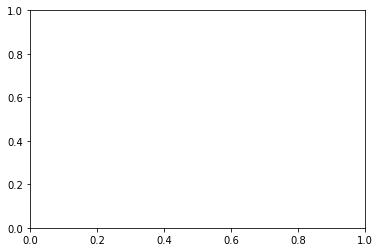

In [16]:
for genre in top_genre:
  if genre == '' or genre == 'nan'
    index = top_genre.index(genre)
    top_genre.remove(genre)
    names.remove


freq = {} 
for item in top_genre: 
  if (item in freq): 
    freq[item] += 1
  else: 
    freq[item] = 1

plt.bar(freq.keys(), freq.values(), color='g')

In [6]:
#category_tensor = torch.tensor(y_train, dtype=torch.long)
#line_tensor = lineToTensor(X_train)
import random
import collections


def randomChoice(l):
    return random.choice(list(l))

def randomTrainingExample():
    category = randomChoice(top_genre)
    line = randomChoice(names)
    #print(category)
    #print(ind[category])
    category_tensor = torch.tensor([ind[category]], dtype=torch.int64)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Drama / line = Luis Cubillos
category = Drama / line = Samir Ahmed
category = Drama / line = Kate Grusovin
category = Drama / line = Katie Gerathy
category = nan / line = Michel Bacora
category = Adventure / line = Chien Yu
category = Comedy / line = Sini Wong
category = Action / line = Agnès Regolo
category = Drama / line = Maria Zabczynska
category = Sci-Fi / line = Janis Farley


In [0]:
criterion = nn.NLLLoss()

In [0]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    #print(output)
    #print(line_tensor.size)
    #print(category_tensor)
    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()
  
 

In [0]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    key_list = list(new_d.keys())
    return key_list[category_i], category_i


  #print(categoryFromOutput(output))

In [10]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (11m 39s) 1.3648 Rosario Velázquez / Comedy ✗ (Drama)
10000 10% (23m 42s) 5.5984 Jörg Pfennigwerth / Drama ✗ (Mystery)
15000 15% (35m 45s) 1.4517 Ekaterina Osmyalovskaya / Drama ✗ (Comedy)
20000 20% (47m 48s) 1.3891 Dino L. Rivera / Comedy ✗ (Drama)
25000 25% (59m 50s) 1.5145 David MacIsaac / Drama ✗ (Comedy)
30000 30% (71m 56s) 1.3483 Deirdre L. Cowden / Drama ✓
35000 35% (84m 4s) 1.4294 Bill Brewer / Comedy ✗ (Drama)
40000 40% (96m 7s) 6.6159 Ivadell Carter / Comedy ✗ (Game-Show)
45000 45% (108m 12s) 4.9284 Jenna Percy / Drama ✗ (Sci-Fi)
50000 50% (120m 24s) 1.3561 Simone Max / Drama ✗ (Comedy)
55000 55% (132m 27s) 4.0725 Magnus Lundblad / Drama ✗ (Short)
60000 60% (144m 33s) 5.5925 Louis Bailey / Drama ✗ (Romance)
65000 65% (156m 34s) 1.2250 Richard Hendry / Drama ✓
70000 70% (168m 37s) 5.1591 Carmen Cardenal / Drama ✗ (Romance)
75000 75% (180m 35s) 5.5978 Victoria Preston / Drama ✗ (Sci-Fi)
80000 80% (192m 36s) 1.0574 Jeanne Madden / Drama ✓
85000 85% (204m 35s) 3.1286 Maya

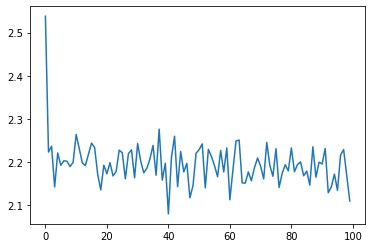

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
# Since there are 1000s of examples we print only every print_every examples, and take an average of the loss.

In [12]:
print(ind)
print(all_losses)

{'Drama': 0, 'Adventure': 1, 'Action': 2, 'Crime': 3, 'Biography': 4, 'Comedy': 5, 'Mystery': 6, 'Horror': 7, 'Fantasy': 8, 'Adult': 9, 'Romance': 10, 'Family': 11, nan: 12, 'Animation': 13, 'Thriller': 14, 'Musical': 15, 'Film-Noir': 16, 'Documentary': 17, 'Talk-Show': 18, 'Sci-Fi': 19, 'Western': 20, 'Short': 21, 'Music': 22, 'Reality-TV': 23, 'Game-Show': 24, 'History': 25, 'News': 26, 'Sport': 27, 'War': 28}
[2.538025091141462, 2.222855419397354, 2.2365236345529556, 2.141925671637058, 2.220746286869049, 2.192214493215084, 2.202529092669487, 2.201650356411934, 2.1892278062105177, 2.1988326295018195, 2.2635706526637076, 2.2312260755896567, 2.1976645562052726, 2.191623649597168, 2.2178081249594688, 2.2435160735845567, 2.2336835361123084, 2.1713130605220794, 2.1351239530444146, 2.1923113179802893, 2.1724255794286726, 2.198325934648514, 2.1675240994691847, 2.177603297352791, 2.2273979831933977, 2.2212810736894606, 2.1606121168136596, 2.2191337349414826, 2.2278612891435623, 2.16320483005

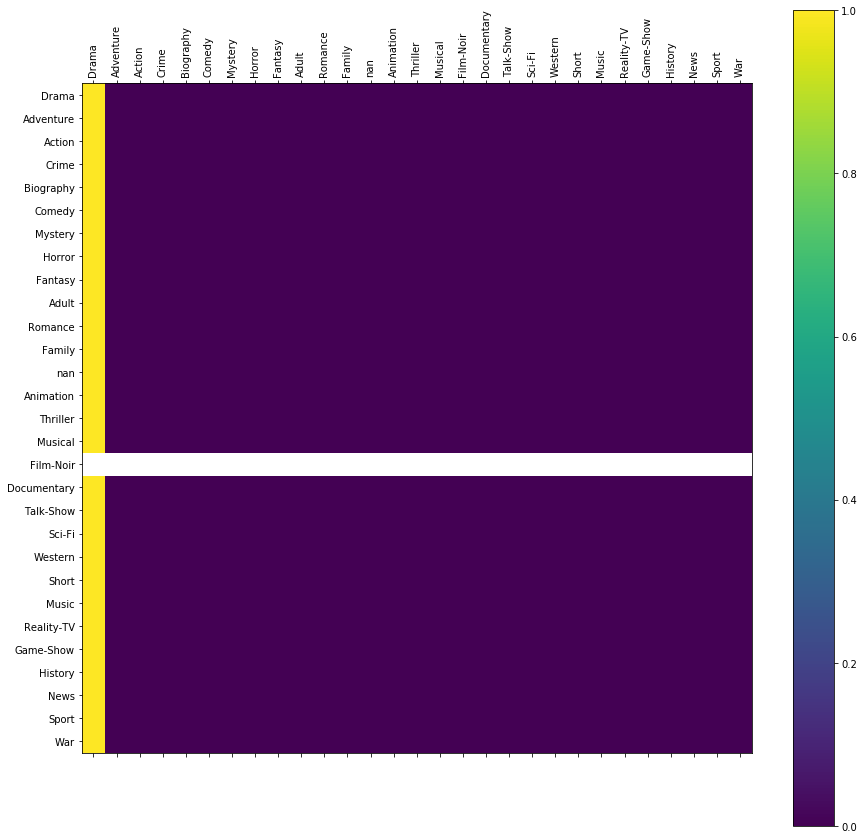

In [13]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = ind[category]
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + list(ind.keys()), rotation=90)
ax.set_yticklabels([''] + list(ind.keys()))

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()